# U-Net 

Vamos a constuir una arquitecutra U-Net básica (con y sin dropout) para realizar segmentación semántica del dataset 



## 1. Importamos librerías

In [87]:
import os
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

## 2. Definimos configuración básica

In [36]:
batch_size = 16
epochs = 40
data_path_train = "png/train"    # Directorio de las imágenes y mascaras de entrenamiento
data_path_train_mask = "png/train_labels"    # Directorio de las imágenes y mascaras de entrenamiento
data_path_test = "png/test"      # Directorio de las imágenes de pruebas
data_path_test_mask = "png/test_labels"      # Directorio de las imágenes de pruebas
data_path_val_mask= "png/val_labels"      # Directorio de las imágenes de validación
data_path_val = "png/val"      # Directorio de las imágenes de validación

## 3. Adecuamos el dataset

In [37]:
import os
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tqdm import tqdm


# Definir las dimensiones de las imágenes
height_shape = 224
width_shape = 224

# Obtener una lista con los archivos dentro de cada carpeta
data_list_train = os.listdir(data_path_train)
data_list_test = os.listdir(data_path_test)
data_list_train_mask = os.listdir(data_path_train_mask)
data_list_test_mask = os.listdir(data_path_test_mask)
data_list_val = os.listdir(data_path_val)
data_list_val_mask = os.listdir(data_path_val_mask)

# Definir listas para guardar cada elemento del dataset
Xtrain = [] 
Ytrain = []
Xtest = []
Ytest = []
Xval = []
Yval = []

# Recorrer la carpeta train
for file_name in tqdm(data_list_train):
    # Leer la imagen de entrenamiento
    img = imread(os.path.join(data_path_train, file_name))[:,:,:3]  
    # Redimensionar la imagen
    img = resize(img, (height_shape, width_shape), mode='constant', preserve_range=True)
    # Agregar la imagen a la lista Xtrain
    Xtrain.append(img)
    
for name_file in tqdm(data_list_train_mask):
        # Leer cada una de las máscaras binarias y redimensionarlas
        maskt = imread(os.path.join(data_path_train_mask, name_file))[:,:,1]
        maskt = resize(maskt, (height_shape, width_shape), mode='constant', preserve_range=True)
        
    
    # Agregar cada máscara a la lista Ytrain
        Ytrain.append(maskt)

# Recorrer la carpeta test
for file_name in tqdm(data_list_test):
    # Leer la imagen de prueba
    img = imread(os.path.join(data_path_test, file_name))[:,:,:3]  
    # Redimensionar la imagen
    img = resize(img, (height_shape, width_shape), mode='constant', preserve_range=True)
    # Agregar la imagen a la lista Xtest
    Xtest.append(img)

for name_file in tqdm(data_list_test_mask):
        # Leer cada una de las máscaras binarias y redimensionarlas
        maskt = imread(os.path.join(data_path_test_mask, name_file))[:,:,1]
        maskt = resize(maskt, (height_shape, width_shape), mode='constant', preserve_range=True)
    
    # Agregar cada máscara a la lista Ytest
        Ytest.append(maskt)

for name_file in tqdm(data_list_val):
    # Leer la imagen de prueba
    img = imread(os.path.join(data_path_val, name_file))[:,:,:3]  
    # Redimensionar la imagen
    img = resize(img, (height_shape, width_shape), mode='constant', preserve_range=True)
    # Agregar la imagen a la lista Xtest
    Xval.append(img)

for name_file in tqdm(data_list_val_mask):
        # Leer cada una de las máscaras binarias y redimensionarlas
        maskt = imread(os.path.join(data_path_val_mask, name_file))[:,:,1]
        maskt = resize(maskt, (height_shape, width_shape), mode='constant', preserve_range=True)
    
    # Agregar cada máscara a la lista Ytest
        Yval.append(maskt)

# Convertir las listas en arrays NumPy
X_train = np.asarray(Xtrain, dtype=np.uint8)
print('Xtrain:', X_train.shape)

Y_train = np.asarray(Ytrain, dtype=bool)
print('Ytrain:', Y_train.shape)

X_test = np.asarray(Xtest, dtype=np.uint8)
print('Xtest:', X_test.shape)

Y_test = np.asarray(Ytest, dtype=bool)
print('Ytest:', Y_test.shape)

X_val = np.asarray(Xval, dtype=np.uint8)
print('Xval:', X_val.shape)

Y_val = np.asarray(Yval, dtype=bool)
print('Yval:', Y_val.shape)

100%|██████████| 4/4 [00:00<00:00, 12.06it/s]


Xtrain: (137, 224, 224, 3)
Ytrain: (137, 224, 224)
Xtest: (10, 224, 224, 3)
Ytest: (10, 224, 224)
Xval: (4, 224, 224, 3)
Yval: (4, 224, 224)


## 4. Mostramos algún elemento del dataset

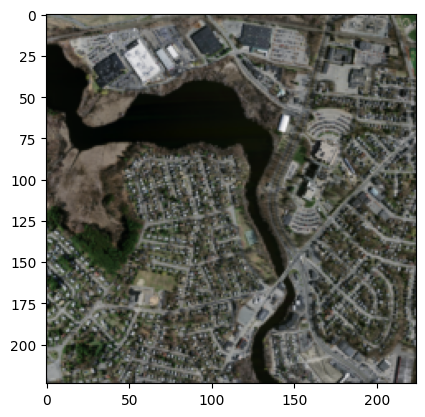

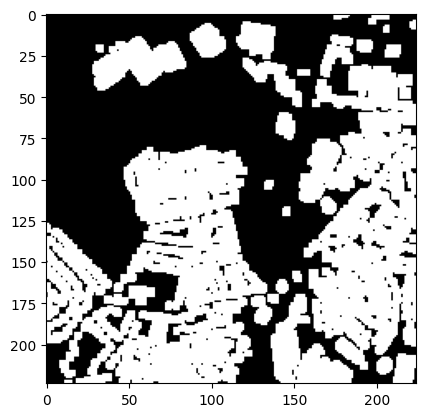

In [38]:
# Mostramos la imagen y su mascara asociada
plt.imshow(X_train[0])
plt.show()
plt.imshow(np.squeeze(Y_train[0]), cmap='gray')
plt.show()

## 5. Creamos un modelo básico de U-Net

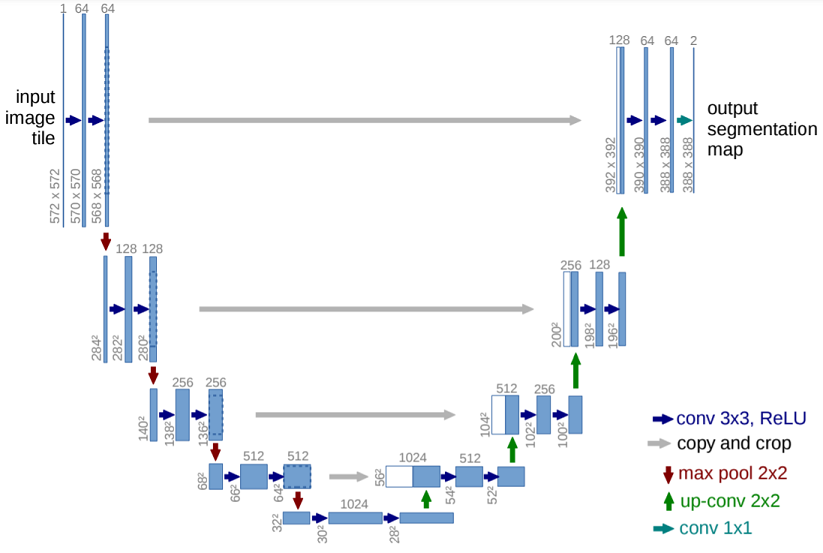

In [39]:
# Definimos la entrada al modelo
Image_input = Input((height_shape, width_shape, 3))
Image_in = Lambda(lambda x: x / 255)(Image_input)

#contracting path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(Image_in)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)
 
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)
 
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
 
up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
 
up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
 
up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
model = Model(inputs=[Image_input], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 224, 224,  │      1,792 │ lambda_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 224, 224,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 112, 112,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 56, 56,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 56, 56,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 28, 28,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 28, 28,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 14, 14,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 14, 14,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 14, 14,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 28, 28,    │  2,097,664 │ conv2d_28[0][0] 

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Creamos un modelo U-Net con Dropout

In [ ]:
# Definimos la entrada al modelo con dropout que en principio no vamos a utilizar.

# inputs = Lambda(lambda x: x / 255)(Input((height_shape, width_shape, 3)))

# #contracting path
# conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
# conv1 = Dropout(0.1)(conv1)
# conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
# maxp1 = MaxPooling2D((2, 2))(conv1)

# conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
# conv2 = Dropout(0.1)(conv2)
# conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
# maxp2 = MaxPooling2D((2, 2))(conv2)
 
# conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
# conv3 = Dropout(0.2)(conv3)
# conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
# maxp3 = MaxPooling2D((2, 2))(conv3)
 
# conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
# conv4 = Dropout(0.2)(conv4)
# conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
# maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
# conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
# conv5 = Dropout(0.3)(conv5)
# conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

# #expansive path
# up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
# up6 = concatenate([up6, conv4])
# conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
# conv6 = Dropout(0.2)(conv6)
# conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
 
# up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
# up7 = concatenate([up7, conv3])
# conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
# conv7 = Dropout(0.2)(conv7)
# conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
 
# up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
# up8 = concatenate([up8, conv2])
# conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
# conv8 = Dropout(0.1)(conv8)
# conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
 
# up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
# up9 = concatenate([up9, conv1], axis=3)
# conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
# conv9 = Dropout(0.1)(conv9)
# conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
 
# outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
# model = Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

## 7. Configuramos Tensorboard

In [40]:
from tensorflow.keras.callbacks import TensorBoard

# Cargamos la extensión, definimos la carpeta logs para guardar los datos de entrenamiento, y definimos el callback
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

## 8. Entrenamos el modelo

In [41]:
results = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=batch_size, epochs=epochs, callbacks=[tensorboard_callback])


Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 120s 12s/step - accuracy: 0.5221 - loss: 0.6877 - val_accuracy: 0.7230 - val_loss: 0.6842
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 124s 13s/step - accuracy: 0.6117 - loss: 0.6844 - val_accuracy: 0.7852 - val_loss: 0.6561
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 117s 13s/step - accuracy: 0.6790 - loss: 0.6590 - val_accuracy: 0.6781 - val_loss: 0.6514
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 118s 13s/step - accuracy: 0.6289 - loss: 0.6976 - val_accuracy: 0.6316 - val_loss: 0.6252
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 120s 13s/step - accuracy: 0.6032 - loss: 0.7492 - val_accuracy: 0.7489 - val_loss: 0.6460
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 130s 15s/step - accuracy: 0.6739 - loss: 0.6519 - val_accuracy: 0.7022 - val_loss: 0.6139
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 122s 14s/step - accuracy: 0.6021 - loss: 0.6664 - val_accuracy: 0.7656 - val_loss: 0.6149
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 114s 13s/step - accuracy: 0.7114 - loss: 0.6172 - val_accuracy: 0.7766 - val_loss:

## 10. Probamos el modelo con alguna imagen de prueba

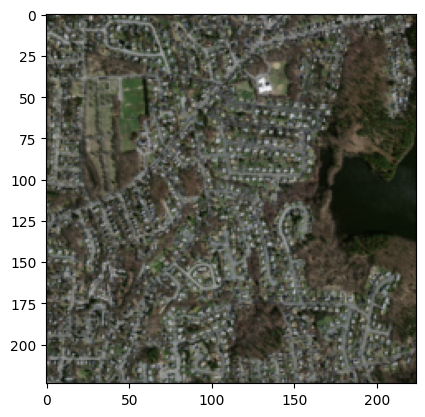

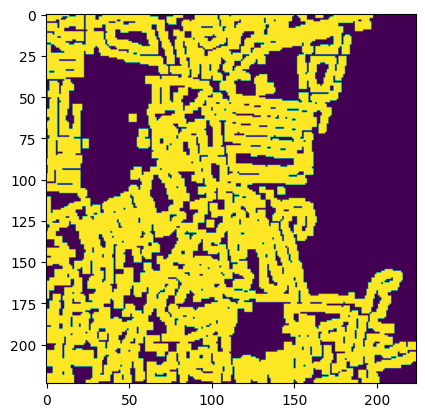

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


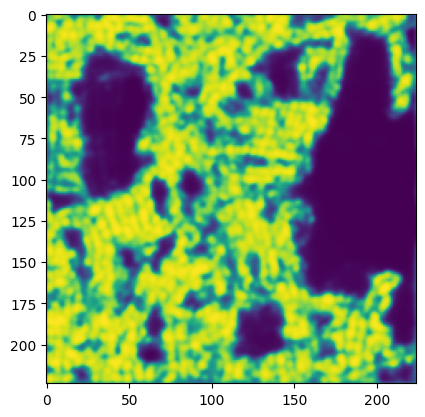

In [64]:
plt.imshow(X_val[1])
plt.show()
plt.imshow(np.squeeze(Y_val[1]))
plt.show()
preds = model.predict(X_val)
plt.imshow(np.squeeze(preds[1]))
plt.show()


Notamos que el modelo, con una accuracy en test de 0.89, es capaz de segmentar notablemente bien las imágenes de validación, e incluso podría mejorarse con un mayor número de épocas de entrenamiento y modificando la profundidad de la red. $\\$ Además, notamos en la esquina superior de la imagen arriba que el podelo podría estar capturando mejor nuestra imagen original que la máscara.


In [78]:
print(preds.shape)

# Las distribuciones de probabilidad
print(preds[1,196,68,:])


(4, 224, 224, 1)
[0.34985915]


El píxel (196, 68) de la primera imagen tiene una probabilidad de 0.3499 de ser un píxel de la clase 1 (edificio).

Lo que haré a continuación es binarizar las predicciones, es decir, si la probabilidad de que un pixel sea de la clase 1 (edificio) es mayor a 0.5, entonces se considerará que el pixel pertenece a la clase 1, en caso contrario, se considerará que pertenece a la clase 0 (background).
Se puede jugar con el umbral para obtener mejores resultados o incluso utilizar una métrica como el F1-score para encontrar el mejor umbral.

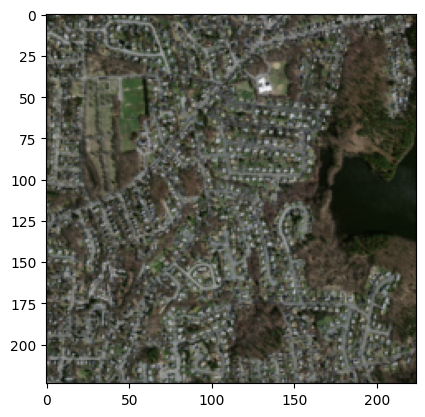

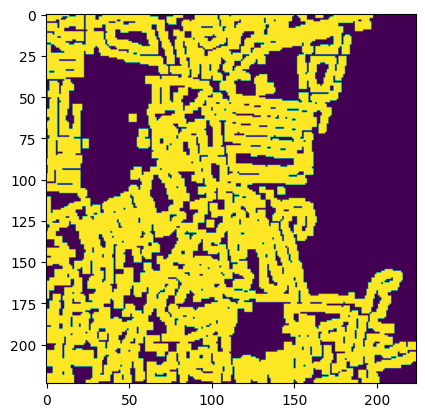

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


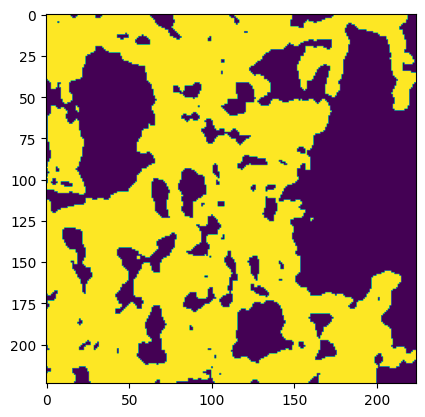

In [79]:
import matplotlib.pyplot as plt

# Definir función para aplicar threshold
def apply_threshold(preds, threshold):
    return (preds > threshold).astype(int)

# Definir threshold
threshold = 0.5

# Visualizar imágenes
plt.imshow(X_val[1])
plt.show()

plt.imshow(np.squeeze(Y_val[1]))
plt.show()

# Obtener predicciones del modelo
preds = model.predict(X_val)

# Binarizar predicciones
binary_preds = apply_threshold(preds[1], threshold)

# Visualizar predicciones binarizadas
plt.imshow(np.squeeze(binary_preds))
plt.show()


## 10. Guardamos el modelo que hemos entrenado anteriormente.

In [91]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model.save('../modeldef.h5')


## 11. Cargar el modelo 

In [2]:
from tensorflow.keras.models import load_model
modelo_cargado_def= load_model('../modeldef.h5')

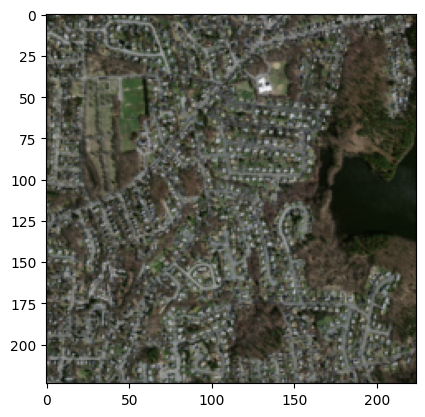

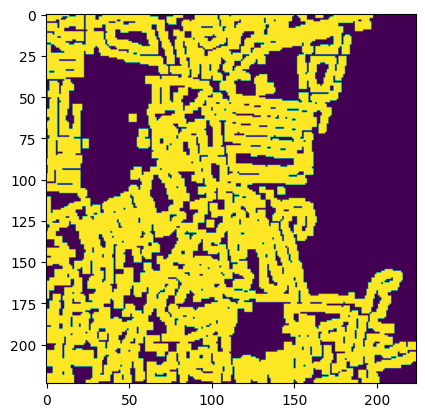

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


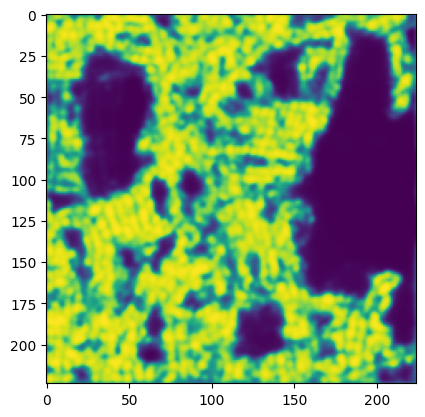

In [97]:
plt.imshow(X_val[1])
plt.show()
plt.imshow(np.squeeze(Y_val[1]))
plt.show()
predsdef = modelo_cargado_def.predict(X_val)
plt.imshow(np.squeeze(predsdef[1]))
plt.show()


In [98]:
print(preds.shape)
# Las distribuciones de probabilidad
print(predsdef[1,196,68,:])

(4, 224, 224, 1)
[0.34985915]


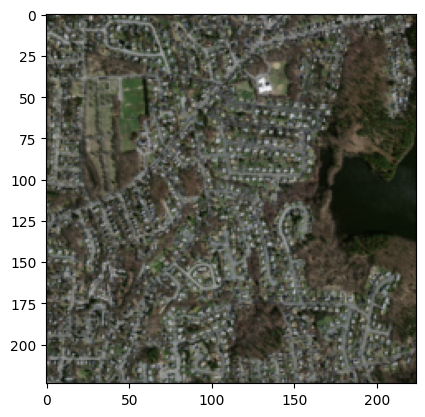

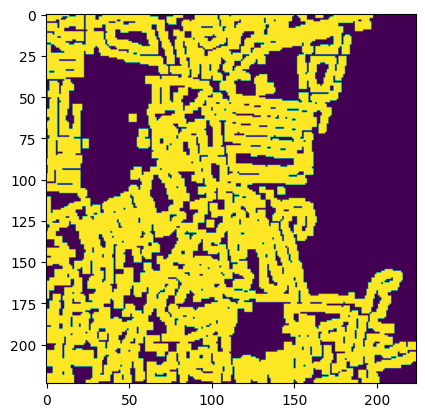

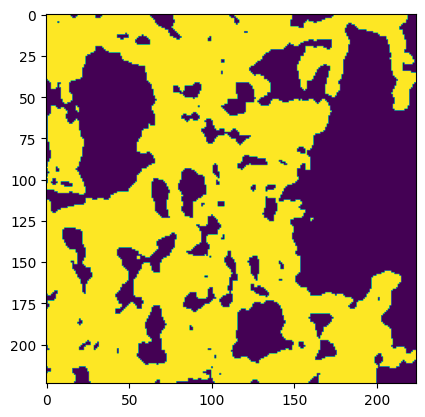

In [99]:
import matplotlib.pyplot as plt

# Definir función para aplicar threshold
def apply_threshold(preds, threshold):
    return (preds > threshold).astype(int)

# Definir threshold
threshold = 0.5

# Visualizar imágenes
plt.imshow(X_val[1])
plt.show()

plt.imshow(np.squeeze(Y_val[1]))
plt.show()

binary_predsdef = apply_threshold(predsdef[1], threshold)

# Visualizar predicciones binarizadas
plt.imshow(np.squeeze(binary_predsdef))
plt.show()
